# Parse ariel3_thunderstorm-noise

This is a quick Python example of parsing a tiny part of the relatively complicated Ariel3 satellite thunderstorm-noise data.

* Inspired by breqm76
* File format documentation at
https://docs.google.com/document/d/1GioN-8mch3GeruMrqG6qVLklQRDOh1TiARfYwI7BC4k/edit#heading=h.uydog7egy1sz
* Parsing the files at https://spdf.sci.gsfc.nasa.gov/pub/data/ariel/ariel3/langmuir_probe/plasma-frequency_electron-temperature_thunderstorm-noise/DATA2_DR002129_DR002129_20080804_091423/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks_cwt

In [2]:
%matplotlib inline

In [3]:
def chunkstring(string, length):
    "Return the string, split up into fixed-width substrings of given length"
    return (string[0+i:length+i] for i in range(0, len(string), length))

def groupOf10(data, offset):
    "print the data as 10 sets of three 5-character numbers"    
    segment = data[offset:offset+10*3*5]
    print('\n'.join(chunkstring(' '.join(chunkstring(segment[:30*5],5)), 18)))

In [4]:
# File is encoded as EBCDIC (codec cp500)
with open('dr002129_f00001.phys.1', 'rt', encoding='cp500') as ariel3_thunderstorm_noise:
    d2129 = ariel3_thunderstorm_noise.read()

In [5]:
groupOf10(d2129, 0x11F02)

 -6.1  -9.0 -14.3 
 -6.2  -9.1 -14.4 
 -6.5  -9.1 -14.4 
 -6.8  -9.2 -14.5 
 -7.0  -9.3 -14.6 
 -7.2  -9.4 -14.7 
 -7.4  -9.5 -14.8 
 -7.6  -9.7 -14.9 
 -7.8  -9.8 -15.0 
 -8.0  -9.9 -15.1


In [6]:
groupOf10(d2129, 0x11FA6)

 -8.1 -10.0 -15.2 
 -8.2 -10.1 -15.3 
 -8.3 -10.2 -15.4 
 -8.4 -10.3 -15.5 
 -8.4 -10.4 -15.6 
 -8.5 -10.5 -15.7 
 -8.5 -10.6 -15.8 
 -8.6 -10.7 -15.9 
 -8.8 -10.8 -16.0 
 -9.0 -10.9 -16.1


# Find length of repeating records: peak autocorrelation

In [7]:
def findRecordLen(segment, maxLen=1000):
    "Find record length in given string, via autocorrelation"

    # Turn string into array of byte with zero mean
    arr = np.array([float(ord(c)) for c in segment])
    arrNorm = arr - np.mean(arr)

    (lags, c, line, b) = plt.acorr(arrNorm, maxlags=maxLen)
    
    return c[maxLen+1:].argmax() + 1

In [8]:
segmentLen = 10000

In [9]:
data = d2129

In [10]:
fileLen = len(data)

In [11]:
print(fileLen)

3270980


## Comparing the file with itself shifted between -1000 and 1000 bytes, the autocorrelation shows that every 164, and especially every 328 bytes there is a strong similarity

328

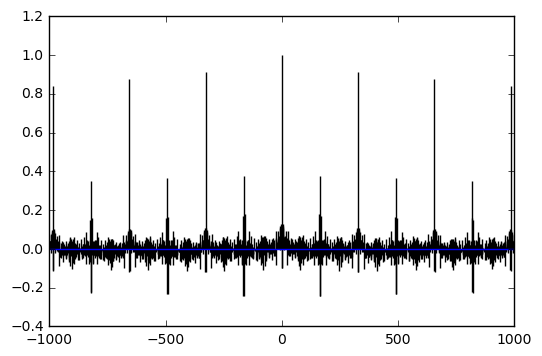

In [12]:
findRecordLen(data[:segmentLen])

## We see the same record length looking at segments all the way thru the file, every 1/10th of the way.

327098 328
654196 328
981294 328
1308392 328
1635490 328
1962588 328
2289686 328
2616784 328
2943882 328


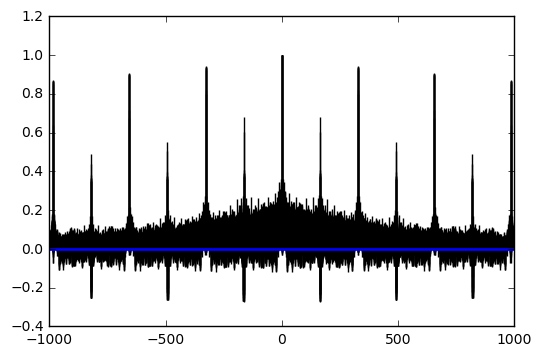

In [13]:
for offset in range(fileLen // 10, fileLen, fileLen // 10):
    print("%d %d" % (offset, findRecordLen(data[offset:offset+segmentLen])))

## The file length is actually a perfect multiple of that smaller segment length

In [14]:
fileLen / 328

9972.5

In [15]:
fileLen / 164

19945.0

In [16]:
fileLen % 164

0

## There is more variation if we look at a segment 1/10 or 2/10 of the way thru the file

In [17]:
offset = fileLen // 10

328

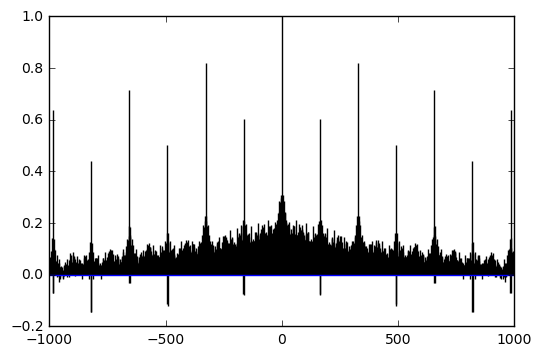

In [18]:
findRecordLen(data[offset:offset+segmentLen])

## But not later

In [19]:
i=4

328

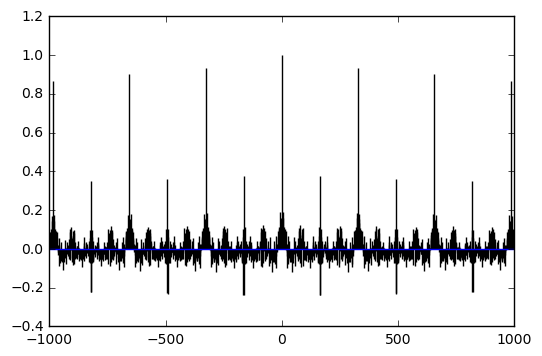

In [20]:
findRecordLen(data[offset*i:offset*i+segmentLen])

# Earlier looking and playing around 

Fields in each record of section 1, "5 MHz or 15MHz data records"

F4.0, A2, 3F3.0, F5.2, F7.3, F8.3, F5.1, F4.0, F3.0, F5.2, F4.1, F5.2, 2F6.1, 2(F6.1, F4.1), F61, F5.2, 3F5.0, 3F6.2

In [21]:
# estimate length of records in section 1
4 + 2 + 9 + 5 + 7 + 8 + 5 + 4 + 3 + 5 + 4 + 5 + 12 + 2*(6+4) + 61 + 5 + 3*5 + 3*6

192

In [22]:
headerLength = 174 # empirically noticed repeat of pairs of records with this chunking
header = d2129[:headerLength]

offset = headerLength
sOneLength = 164
M = 424

section1 = d2129[offset:offset+(M * sOneLength)]


In [23]:
header

'\x00s                 131    4                 MAD                     0                                                                                     0000000000\x00s  1.  15'

Print the first half or so of each record in what seem to be pretty regular repeats in section 1. There seems to be a smaller interval after the odd records than after the even ones

In [24]:
["%4d %s" % (i, l[:80]) for i, l in enumerate(list(chunkstring(section1, 164)))]

['   0 . 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.',
 '   1  2.26.70 -1.577  69.605506.6  7.40.51.8010.9 3.672100.0  20.9 -10.4 0.0 -10.4 0.',
 '   2 . 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.',
 '   3  2.54.60 -3.336  69.792507.6  7.42. 4.6010.8 3.762100.0  20.9 -10.5 0.0 -10.5 0.',
 '   4 . 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.',
 '   5  3.22.60 -5.094  69.979508.7  7.43.17.4010.6 3.792100.0  21.1 -10.6 0.0 -10.6 0.',
 '   6 . 3. 3.47.00 -6.631  70.144509.7  7.44.21.5010.4 3.812100.0  21.1 -16.0 0.0 -16.',
 '   7  3.50.50 -6.851  70.167509.9  7.44.30.6010.3 3.812100.0  21.1 -10.7 0.0 -10.7 0.',
 '   8 . 3. 4.14.90 -8.388  70.334510.9  7.45.35.1010.1 3.762100.0  20.9 -16.1 0.0 -16.',
 '   9  4.18.40 -8.607  70.358511.1  7.45.44.3010.0 3.762100.0  20.9 -10.8 0.0 -10.8 0.',
 '  10 . 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.',
 '  11  4.

So it's a bit cleaner (but we miss half the records) to look every 328 bytes:

In [25]:
["%4d %s" % (i, l[:80]) for i, l in enumerate(list(chunkstring(section1, 328)))]

['   0 . 3. 2.23.20 -1.357  69.581506.5  7.40.42.8010.9 3.672100.0  20.9 -15.7 0.0 -15.',
 '   1 . 3. 2.51.10 -3.116  69.768507.5  7.41.55.5010.8 3.762100.0  20.9 -15.8 0.0 -15.',
 '   2 . 3. 3.19.10 -4.874  69.955508.6  7.43. 8.3010.6 3.792100.0  21.1 -15.9 0.0 -15.',
 '   3 . 3. 3.47.00 -6.631  70.144509.7  7.44.21.5010.4 3.812100.0  21.1 -16.0 0.0 -16.',
 '   4 . 3. 4.14.90 -8.388  70.334510.9  7.45.35.1010.1 3.762100.0  20.9 -16.1 0.0 -16.',
 '   5 . 3. 4.42.80-10.144  70.528512.2  7.46.49.40 9.8 3.672100.0  20.9 -16.2 0.0 -16.',
 '   6 . 3. 5.10.70-11.898  70.725513.6  7.48. 4.70 9.4 3.552100.0  20.9 -16.3 0.0 -16.',
 '   7 . 3. 5.38.70-13.651  70.926515.0  7.49.20.80 9.2 3.652100.0  20.6 -16.4 0.0 -16.',
 '   8 . 3. 6. 6.60-15.403  71.131516.5  7.50.38.00 8.9 3.612100.0  20.9 -16.5 0.0 -16.',
 '   9 . 3. 6.34.50-17.154  71.341518.1  7.51.56.40 8.6 3.552100.0  20.9 -16.6 0.0 -16.',
 '  10 . 3. 7. 2.40-18.903  71.558519.7  7.53.16.30 8.4 3.452100.0  20.9 -16.7 0.0 -16.',
 '  11 . 3

# Now older random poking around....

In [26]:
gap = '. 0. 0. 0.00  0.000   0.000  0.0  0. 0. 0.00 0.0 0.00   0.0   0.0   0.0 0.0   0.0 0.0   0.0 0.00   0.   0.   0.  0.00  0.00  0.00                       00\x00s  25                                                                                                                                                            00\x00s    2.2  -71.4                                                                                                                                                  00\x00s     2   212                                                                                                                                                    00\x00s '

In [27]:
len(gap)

649

In [28]:

offset = headerLength + M * sOneLength + 677
sTwoLength = 10 * 3 * 5
section2 = d2129[offset:offset+(M * sTwoLength)]


In [29]:
groupOf10(section2, sTwoLength)

 -9.3 -11.5 -16.8 
 -9.5 -11.6 -16.8 
 -9.5 -11.7 -16.9 
 -9.5 -11.7 -17.0 
 -9.6 -11.8 -17.0 
 -9.7 -11.8 -17.1 
 -9.9 -11.9 -17.1 
 -9.9 -11.9 -17.2 
 -9.9 -12.0 -17.2 
            00 s-


In [30]:
groupOf10(section2[sTwoLength:], sTwoLength)

10.0- 12.0- 17.2- 
10.1- 12.1- 17.3- 
10.1- 12.1- 17.3- 
10.2- 12.1- 17.3- 
10.3- 12.1- 17.4- 
10.2- 12.1- 17.4- 
10.2- 12.2- 17.4- 
10.2- 12.2- 17.4- 
10.1- 12.1- 17.4- 
10.1- 12.2- 17.4 


164

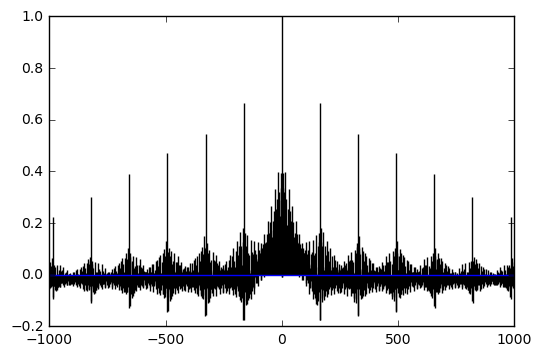

In [31]:
findRecordLen(data[M * sOneLength + 677:M * sOneLength + 677+sTwoLength*10])

In [32]:
data[headerLength + M * sOneLength + 677:headerLength + M * sOneLength + 677+sTwoLength*10]

'8 -7.9-10.6-15.9 -7.9-10.7-16.0 -8.1-10.8-16.1 -8.3-11.0-16.2 -8.6-11.1-16.3 -8.6-11.1-16.4 -8.7-11.2-16.5 -8.8-11.3-16.6          00\x00s -9.0-11.4-16.7 -9.3-11.5-16.8 -9.5-11.6-16.8 -9.5-11.7-16.9 -9.5-11.7-17.0 -9.6-11.8-17.0 -9.7-11.8-17.1 -9.9-11.9-17.1 -9.9-11.9-17.2 -9.9-12.0-17.2          00\x00s-10.0-12.0-17.2-10.1-12.1-17.3-10.1-12.1-17.3-10.2-12.1-17.3-10.3-12.1-17.4-10.2-12.1-17.4-10.2-12.2-17.4-10.2-12.2-17.4-10.1-12.1-17.4-10.1-12.2-17.4          00\x00s-10.1-12.1-17.4 -9.5-12.1-17.3-10.1-12.1-17.4 -9.4-12.0-17.3 -9.6-12.0-17.3 -9.9-12.1-17.3 -9.5-12.0-17.2-10.0-12.0-17.3-10.5-12.1-17.3-10.4-12.1-17.2          00\x00s -9.8-11.9-17.1 -9.5-11.8-17.1 -9.7-11.8-17.1 -9.6-11.8-17.0 -9.5-11.7-16.9 -6.1-11.3-16.8 -6.6-11.3-16.7 -7.7-11.3-16.7 -8.2-11.3-16.6 -8.9-11.3-16.6          00\x00s -9.1-11.3-16.5 -8.7-11.2-16.4 -8.7-11.1-16.3 -8.8-11.0-16.3 -8.5-10.9-16.2 -8.5-10.8-16.1 -9.2-10.9-16.0 -9.2-10.8-15.9 -9.0-10.7-15.8 -9.1-10.6-15.8          00\x00s -9.0-10.5-15.7 -8.5-10.3-

In [33]:
d = np.array([float(ord(c)) for c in d2129])

In [34]:
segmentraw = d[headerLength:10000]

In [35]:
segment = segmentraw - np.mean(segmentraw)

In [36]:
ac = np.correlate(segment, segment, mode='same')

In [37]:
len(ac)

9826

In [38]:
len(segment)

9826

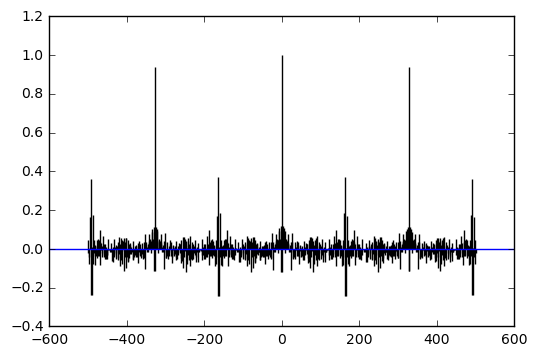

In [39]:
(lags, c, line, b) = plt.acorr(segment, maxlags=500)

peak at 328

In [40]:
indexes = find_peaks_cwt(c, np.arange(1, 550))

In [41]:
indexes

[159, 173, 329, 500, 671, 828, 841, 860, 863, 867]

In [42]:
ac

array([ 54166.11764706,   5834.81577088, -10615.02935789, ...,
        34634.98710504, -10615.02935789,   5834.81577088])

In [43]:
center = ac.argmax()

In [44]:
ac[center+320:center+325]

array([   7057.91179464,   98418.20329019,  110062.09340166,
         38561.95929167,   54536.94282875])

In [45]:
ac[322]

-61695.80966463621

In [46]:
ac[center+1:].argmax()

327

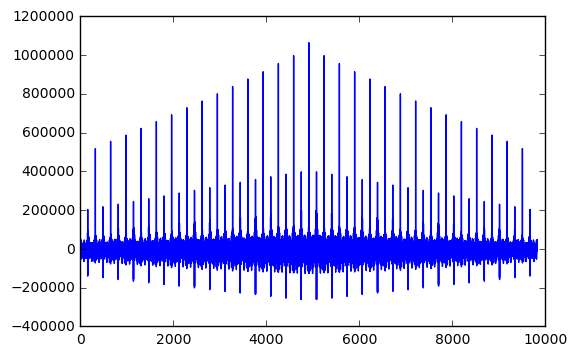

In [47]:
plt.plot(ac)

In [48]:
len(segment)

9826

In [49]:
# times out... (lags, c, line, b) = plt.acorr(d - np.mean(d), maxlags=500)

In [50]:
c[500+320:500+330]

array([ 0.00663063,  0.09246006,  0.10339904,  0.03622745,  0.05123533,
        0.11427109,  0.03218082, -0.11386569,  0.93707748, -0.11588184])

In [51]:
c[500 + 1:].argmax()

327

In [52]:
lags

array([-500, -499, -498, ...,  498,  499,  500])

In [53]:
len(c)

1001

In [54]:
c[10]

0.00080294224440384282